In [1]:
# pandas and numpy for working with data
import pandas as pd 
import numpy as np

# seaborn and matplotlib for visualization
import seaborn as sns
import matplotlib.pyplot as plt

In [90]:
daily_reports = pd.read_csv("../data/csse_covid_19_daily_reports_us.csv")
daily_reports['Date_Last_Update'] = pd.to_datetime(pd.to_datetime(daily_reports.loc[:,'Last_Update']).dt.date)

In [91]:
# import data state population data from https://www.kaggle.com/peretzcohen/2019-census-us-population-data-by-state
population_data = pd.read_csv('../data/2019_Census_US_Population_Data_By_State_Lat_Long.csv')
population_data.rename(columns={'STATE':'State', 'POPESTIMATE2019': 'Total Pop'}, inplace=True)
population_data.drop(columns=['lat','long'], inplace=True)
population_data.head()

,State,Total Pop
0,Alabama,4903185
1,Alaska,731545
2,Arizona,7278717
3,Arkansas,3017804
4,California,39512223


In [92]:
daily_reports = daily_reports.merge(population_data, how='left', left_on='Province_State', right_on='State')
daily_reports.head()

,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,...,Case_Fatality_Ratio,UID,ISO3,Testing_Rate,Hospitalization_Rate,People_Tested,Mortality_Rate,Date_Last_Update,State,Total Pop
0,Alabama,US,2021-01-02 05:30:44,32.3182,-86.9023,365747,4872,202137.0,158738.0,1.0,...,1.332068,84000001.0,USA,38448.804196,NaN,NaN,NaN,2021-01-02,Alabama,4903185.0
1,Alaska,US,2021-01-02 05:30:44,61.3707,-152.4044,46986,206,7165.0,39615.0,2.0,...,0.438428,84000002.0,USA,174391.185778,NaN,NaN,NaN,2021-01-02,Alaska,731545.0
2,American Samoa,US,2021-01-02 05:30:44,-14.2710,-170.1320,0,0,NaN,0.0,60.0,...,NaN,16.0,ASM,3846.084722,NaN,NaN,NaN,2021-01-02,NaN,NaN
3,Arizona,US,2021-01-02 05:30:44,33.7298,-111.4312,530267,9015,76934.0,444318.0,4.0,...,1.700087,84000004.0,USA,39551.860582,NaN,NaN,NaN,2021-01-02,Arizona,7278717.0
4,Arkansas,US,2021-01-02 05:30:44,34.9697,-92.3731,229442,3711,199247.0,26484.0,5.0,...,1.617402,84000005.0,USA,67979.497674,NaN,NaN,NaN,2021-01-02,Arkansas,3017804.0


In [106]:
state_reports = {}
for state in ['California','Oregon','Nevada','New York','New Jersey']:
    state_reports[state] = daily_reports[daily_reports["Province_State"]==state]

In [117]:
state_reports['California'].columns

Index(['Province_State', 'Country_Region', 'Last_Update', 'Lat', 'Long_',
       'Confirmed', 'Deaths', 'Recovered', 'Active', 'FIPS', 'Incident_Rate',
       'Total_Test_Results', 'People_Hospitalized', 'Case_Fatality_Ratio',
       'UID', 'ISO3', 'Testing_Rate', 'Hospitalization_Rate', 'People_Tested',
       'Mortality_Rate', 'Date_Last_Update', 'State', 'Total Pop',
       'Confirmed_prop', 'Deaths_prop', 'Active_prop'],
      dtype='object')

In [122]:
def load_state_data(state):
    return daily_reports[daily_reports["Province_State"]==state]

def create_proportion(data, col_name, total_col, output_name=False):
    if not output_name:
        output_name = col_name + '_prop'
    data_copy = data.copy()
    data_copy.loc[:,output_name] = data[col_name] / data[total_col]
    return data_copy 

def create_proportions(data, cols, total_col):
    for col_name in cols:
        data = create_proportion(data, col_name, total_col)
    return data 


def create_diff(data, col_name, output_name=False):
    if not output_name:
        output_name = col_name + '_diff'
    sorted_data = data.sort_values(by="Date_Last_Update")
    sorted_data.loc[:,output_name] = sorted_data.loc[:,col_name].diff()
    return sorted_data

def create_diffs(data, cols):
    for col_name in cols:
        data = create_diff(data, col_name)
    return data

def create_rolling_average_by_time(data, date_col, col_name, output_name, window_offset):
    temp_df = (data[[date_col,col_name]]
           .set_index(date_col)
           .sort_index()
           .rolling(window_offset).mean().reset_index()
           .rename(columns={col_name:output_name})
          )
    data = data.merge(temp_df, how="left", left_on=date_col, right_on=date_col)
    return data

def apply_pipeline(data):
    return (data.pipe(create_proportions, 
                      cols = ['Confirmed','Deaths','Recovered', 
                              'Active', 'People_Hospitalized'], 
                      total_col = 'Total Pop')
                .pipe(create_diffs, cols=['Confirmed', 'Deaths', 'Recovered', 
                              'Active', 'People_Hospitalized'])
                .pipe(create_diffs, cols=['Confirmed_prop', 'Deaths_prop', 'Recovered_prop', 
                              'Active_prop', 'People_Hospitalized_prop'])
                .pipe(create_rolling_average_by_time, 
                    date_col = 'Date_Last_Update', 
                    col_name = 'Confirmed_prop_diff',
                    output_name = 'Confirmed_prop_diff_rolling_avg_7D', 
                    window_offset = '7D')
                .pipe(create_rolling_average_by_time, 
                    date_col = 'Date_Last_Update', 
                    col_name = 'Deaths_prop_diff',
                    output_name = 'Deaths_prop_diff_rolling_avg_7D', 
                    window_offset = '7D')
            )

In [135]:
state_reports['California'] = apply_pipeline(load_state_data('California'))
state_reports['New York'] = apply_pipeline(load_state_data('New York'))
state_reports['Nevada'] = apply_pipeline(load_state_data('Nevada'))


In [124]:
state_reports['California'].head()

,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,...,Recovered_diff,Active_diff,People_Hospitalized_diff,Confirmed_prop_diff,Deaths_prop_diff,Recovered_prop_diff,Active_prop_diff,People_Hospitalized_prop_diff,Confirmed_prop_diff_rolling_avg_7D,Deaths_prop_diff_rolling_avg_7D
0,California,US,2020-04-12 23:18:15,36.1162,-119.6816,22805,640,NaN,22155.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,California,US,2020-04-13 23:07:54,36.1162,-119.6816,23946,714,NaN,23217.0,6.0,...,NaN,1062.0,-2219.0,0.000029,0.000002,NaN,0.000027,-0.000056,0.000029,0.000002
2,California,US,2020-04-14 23:33:31,36.1162,-119.6816,25373,767,NaN,24589.0,6.0,...,NaN,1372.0,2148.0,0.000036,0.000001,NaN,0.000035,0.000054,0.000032,0.000002
3,California,US,2020-04-15 22:56:51,36.1162,-119.6816,26699,860,NaN,25826.0,6.0,...,NaN,1237.0,0.0,0.000034,0.000002,NaN,0.000031,0.000000,0.000033,0.000002
4,California,US,2020-04-16 23:30:51,36.1162,-119.6816,27687,956,NaN,26721.0,6.0,...,NaN,895.0,-132.0,0.000025,0.000002,NaN,0.000023,-0.000003,0.000031,0.000002


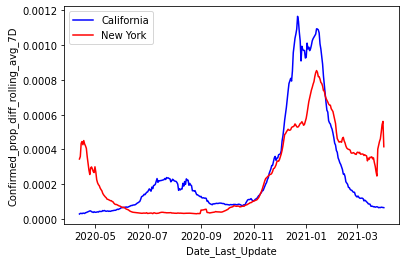

In [125]:
sns.lineplot(data=state_reports['California'], x="Date_Last_Update", y="Confirmed_prop_diff_rolling_avg_7D", color="blue");
sns.lineplot(data=state_reports['New York'], x="Date_Last_Update", y="Confirmed_prop_diff_rolling_avg_7D",color="red");
plt.legend(labels=['California', 'New York']);

In [132]:
def plot_states_over_time(state_names, feature_col, time_col="Date_Last_Update"):
    for state in state_names:
        sns.lineplot(data=state_reports[state], x=time_col, y=feature_col);
#    sns.lineplot(data=state_reports[state2], x=time_col, y=feature_col, color="red");
    plt.legend(labels=state_names);

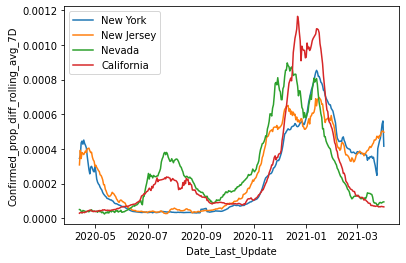

In [136]:
plot_states_over_time(['New York', 'New Jersey', 'Nevada', 'California'], "Confirmed_prop_diff_rolling_avg_7D")

In [111]:
state_reports['California'] = create_proportions(state_reports['California'], ['Confirmed','Deaths','Active'], 'Total Pop')
state_reports['California'].head()

,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,...,Testing_Rate,Hospitalization_Rate,People_Tested,Mortality_Rate,Date_Last_Update,State,Total Pop,Confirmed_prop,Deaths_prop,Active_prop
5,California,US,2021-01-02 05:30:44,36.1162,-119.6816,2365024,26363,NaN,2309915.0,6.0,...,83666.036710,NaN,NaN,NaN,2021-01-02,California,39512223.0,0.059856,0.000667,0.058461
63,California,US,2021-01-03 05:30:33,36.1162,-119.6816,2415246,26551,NaN,2362015.0,6.0,...,84509.145436,NaN,NaN,NaN,2021-01-03,California,39512223.0,0.061127,0.000672,0.059779
121,California,US,2021-01-04 05:30:45,36.1162,-119.6816,2452262,26638,NaN,2400292.0,6.0,...,85575.509128,NaN,NaN,NaN,2021-01-04,California,39512223.0,0.062063,0.000674,0.060748
179,California,US,2021-01-05 05:30:33,36.1162,-119.6816,2490518,27017,NaN,2431220.0,6.0,...,86370.774431,NaN,NaN,NaN,2021-01-05,California,39512223.0,0.063032,0.000684,0.061531
237,California,US,2021-01-06 05:30:39,36.1162,-119.6816,2529480,27519,NaN,2468414.0,6.0,...,86886.490796,NaN,NaN,NaN,2021-01-06,California,39512223.0,0.064018,0.000696,0.062472


In [40]:
state_reports['California'] = create_diffs(state_reports['California'], 'Confirmed')
state_reports['California'] = create_diffs(state_reports['California'], 'Deaths')
state_reports['New York'] = create_diffs(state_reports['New York'], 'Confirmed')
state_reports['New York'] = create_diffs(state_reports['New York'], 'Deaths')
state_reports['California'].head()

,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,...,Case_Fatality_Ratio,UID,ISO3,Testing_Rate,Hospitalization_Rate,People_Tested,Mortality_Rate,Date_Last_Update,Confirmed_diff,Deaths_diff
5224,California,US,2020-04-12 23:18:15,36.1162,-119.6816,22805,640,NaN,22155.0,6.0,...,NaN,84000006.0,USA,485.423869,22.961176,190328.0,2.812020,2020-04-12,NaN,NaN
5284,California,US,2020-04-13 23:07:54,36.1162,-119.6816,23946,714,NaN,23217.0,6.0,...,NaN,84000006.0,USA,486.836823,12.598721,190882.0,2.987756,2020-04-13,1141.0,74.0
5343,California,US,2020-04-14 23:33:31,36.1162,-119.6816,25373,767,NaN,24589.0,6.0,...,NaN,84000006.0,USA,515.723328,20.362044,202208.0,3.028869,2020-04-14,1427.0,53.0
5402,California,US,2020-04-15 22:56:51,36.1162,-119.6816,26699,860,NaN,25826.0,6.0,...,NaN,84000006.0,USA,552.138790,19.347223,216486.0,3.226411,2020-04-15,1326.0,93.0
5461,California,US,2020-04-16 23:30:51,36.1162,-119.6816,27687,956,NaN,26721.0,6.0,...,NaN,84000006.0,USA,628.433237,18.177548,246400.0,3.457745,2020-04-16,988.0,96.0


In [41]:
state_reports['California'] = create_rolling_average_by_time(state_reports['California'],
                                                            'Date_Last_Update', 'Confirmed_diff',
                                                            'Confirmed_diff_rolling_avg_7D', '7D')
state_reports['New York'] = create_rolling_average_by_time(state_reports['New York'],
                                                            'Date_Last_Update', 'Confirmed_diff',
                                                            'Confirmed_diff_rolling_avg_7D', '7D')

In [42]:
state_reports['New York'].head()

,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,...,UID,ISO3,Testing_Rate,Hospitalization_Rate,People_Tested,Mortality_Rate,Date_Last_Update,Confirmed_diff,Deaths_diff,Confirmed_diff_rolling_avg_7D
0,New York,US,2020-04-12 23:18:15,42.1657,-74.9481,189033,9385,23887.0,179648.0,36.0,...,84000036.0,USA,2737.680538,22.532574,461601.0,4.964742,2020-04-12,NaN,NaN,NaN
1,New York,US,2020-04-13 23:07:54,42.1657,-74.9481,195749,10058,23887.0,185691.0,36.0,...,84000036.0,USA,2837.057652,21.819779,478357.0,5.138213,2020-04-13,6716.0,673.0,6716.000000
2,New York,US,2020-04-14 23:33:31,42.1657,-74.9481,203020,10842,23887.0,192178.0,36.0,...,84000036.0,USA,2960.336041,22.756871,499143.0,5.340361,2020-04-14,7271.0,784.0,6993.500000
3,New York,US,2020-04-15 22:56:51,42.1657,-74.9481,214454,11617,23887.0,202837.0,36.0,...,84000036.0,USA,3119.691715,21.543548,526012.0,5.417013,2020-04-15,11434.0,775.0,8473.666667
4,New York,US,2020-04-16 23:30:51,42.1657,-74.9481,223691,14832,23887.0,208859.0,36.0,...,84000036.0,USA,3265.394601,22.553433,550579.0,6.630575,2020-04-16,9237.0,3215.0,8664.500000


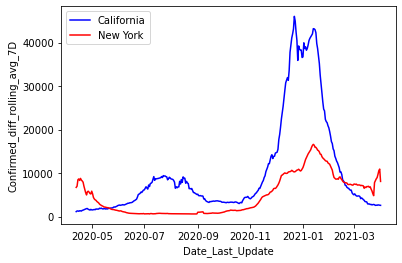

In [51]:
sns.lineplot(data=state_reports['California'], x="Date_Last_Update", y="Confirmed_diff_rolling_avg_7D", color="blue");
sns.lineplot(data=state_reports['New York'], x="Date_Last_Update", y="Confirmed_diff_rolling_avg_7D",color="red");
plt.legend(labels=['California', 'New York']);

In [80]:
state_reports['New Jersey'] = apply_pipeline(load_state_data('New Jersey'))
state_reports['New York'] = apply_pipeline(load_state_data('New York'))
state_reports['California'] = apply_pipeline(load_state_data('California'))

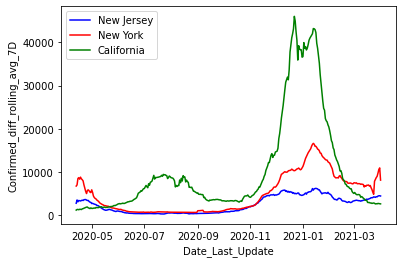

In [81]:
# normalize by population??? 
sns.lineplot(data=state_reports['New Jersey'], x="Date_Last_Update", y="Confirmed_diff_rolling_avg_7D", color="blue");
sns.lineplot(data=state_reports['New York'], x="Date_Last_Update", y="Confirmed_diff_rolling_avg_7D",color="red");
sns.lineplot(data=state_reports['California'], x="Date_Last_Update", y="Confirmed_diff_rolling_avg_7D",color="green");
plt.legend(labels=['New Jersey', 'New York', 'California']);